In [25]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
xdata = xr.open_dataset('AirTempData.nc')

In [3]:
xdata

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 894)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2022-06-01
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            netCDF Operators version 4.8.1 (Homepage = http://nco.sf....
    history:        Thu Aug  4 01:41:34 2022: ncrcat -O -d time,1948-01-01 00...
    title:          monthly mean air.sig995 from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

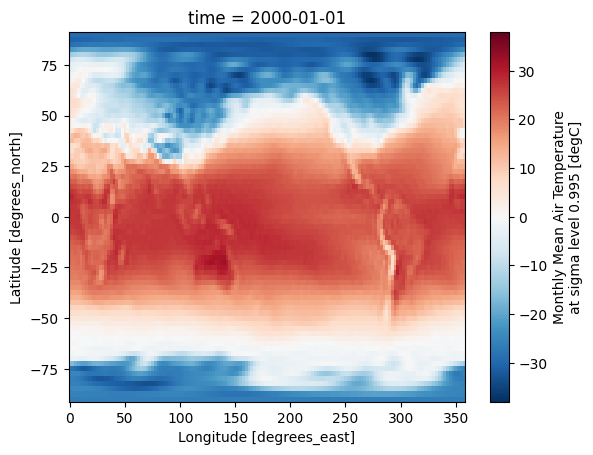

In [4]:
xdata.sel(time='2000-01-01')['air'].plot()

In [5]:
Xregion = xdata.sel(lat=slice(6.,-6.), lon=slice(190.,240.)).mean(dim=['lat', 'lon'])
Yregion = xdata.sel(lat=slice(65.,50.), lon=slice(200.,240.)).mean(dim=['lat', 'lon'])

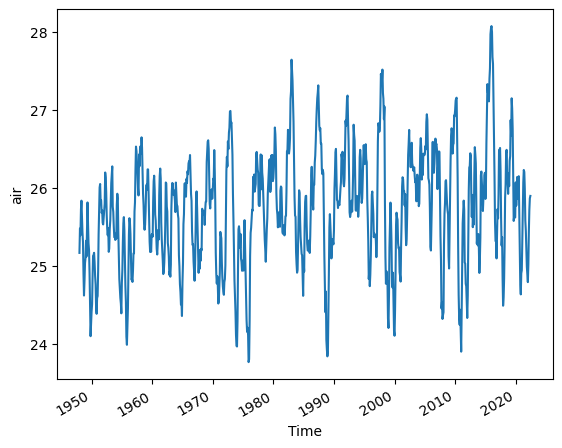

In [6]:
Xregion['air'].plot()

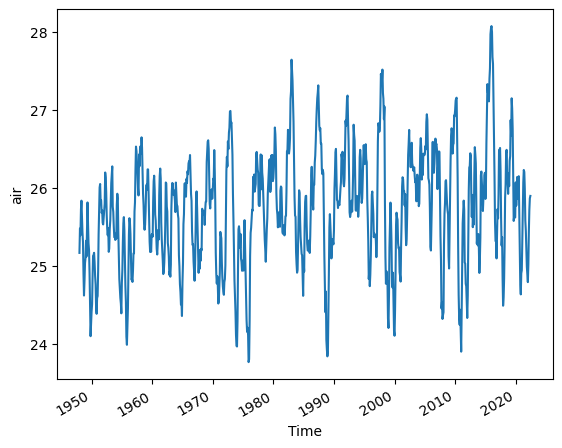

In [7]:
Xregion['air'].plot()

In [8]:
monthlymean = Xregion.groupby("time.month").mean("time")
anomalies_Xregion = Xregion.groupby("time.month") - monthlymean

Yregion_monthlymean = Yregion.groupby("time.month").mean("time")
anomalies_Yregion = Yregion.groupby("time.month") - Yregion_monthlymean

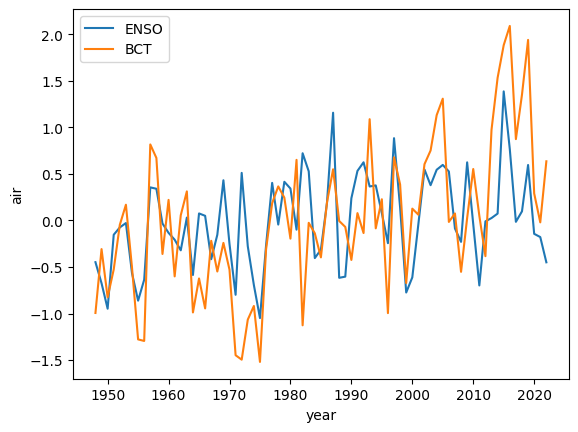

In [27]:
anomalies_Xregion.groupby("time.year").mean("time")['air'].plot(label='ENSO')
anomalies_Yregion.groupby("time.year").mean("time")['air'].plot(label='BCT')
plt.legend()

In [11]:
def is_ond(month):
    return (month >= 10) & (month <= 12)

def is_son(month):
    return (month >= 9) & (month <= 11)

def is_ndj(month):
    return ((month >= 11) & (month <= 12)) or (month==1)

def is_jfm(month):
    return (month >= 1) & (month <= 3)

In [12]:
ond_Xregion = anomalies_Xregion.sel(time=is_ond(xdata['time.month']))

ond_Xregion_by_year = ond_Xregion.groupby("time.year").mean()

# num_ond_Xregion = np.array(ond_Xregion_by_year.to_array())[0]

# reshaped_Xregion = np.reshape(num_ond_Xregion, newshape = (num_ond_Xregion.shape[0],num_ond_Xregion.shape[1]*num_ond_Xregion.shape[2]))

reshaped_Xregion = np.array(ond_Xregion_by_year.to_array())[0]

In [13]:
jfm_Yregion = anomalies_Yregion.sel(time=is_jfm(xdata['time.month']))

jfm_Yregion_by_year = jfm_Yregion.groupby("time.year").mean()

# num_jfm_Yregion = np.array(jfm_Yregion_by_year.to_array())[0]

# reshaped_Yregion = np.reshape(num_jfm_Yregion, newshape = (num_jfm_Yregion.shape[0],num_jfm_Yregion.shape[1]*num_jfm_Yregion.shape[2]))

reshaped_Yregion = np.array(jfm_Yregion_by_year.to_array())[0]

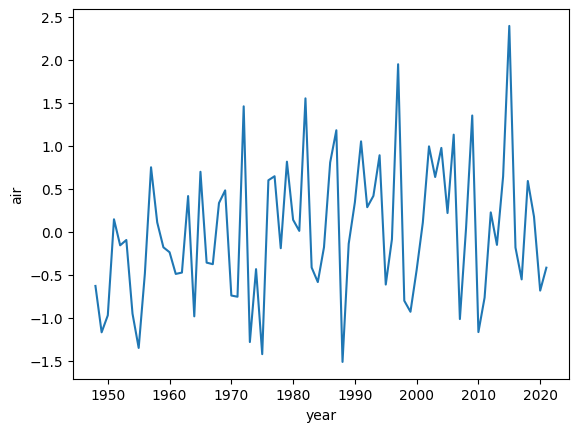

In [14]:
ond_Xregion_by_year['air'].plot()

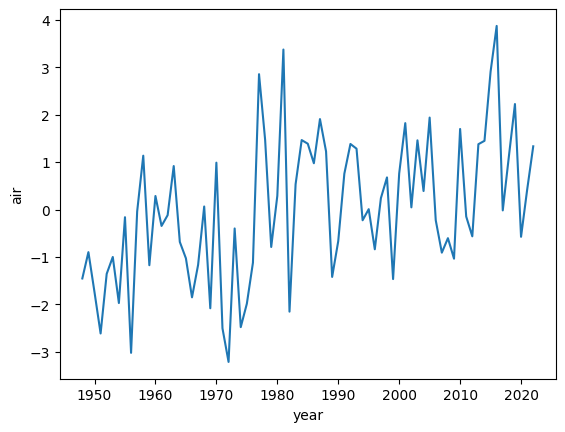

In [15]:
jfm_Yregion_by_year['air'].plot()

Text(0.5, 0, 'Year')

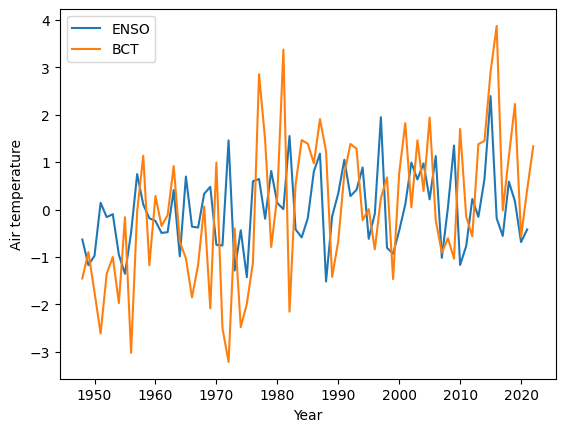

In [30]:
ond_Xregion_by_year['air'].plot(label='ENSO')
jfm_Yregion_by_year['air'].plot(label='BCT')
plt.legend()
plt.ylabel('Air temperature')
plt.xlabel('Year')

In [16]:
def shift_by_one(array1, array2, t):
    if t == 0:
        return array1, array2
    elif t < 0:
        s = -t
        newarray1 = array1[:-s]
        newarray2 = array2[s:]
        return newarray1, newarray2

    else:
        newarray1 = array1[t:]
        newarray2 = array2
        return newarray1, newarray2

In [17]:
ond_Xregion_by_year

<xarray.Dataset>
Dimensions:  (year: 74)
Coordinates:
  * year     (year) int64 1948 1949 1950 1951 1952 ... 2017 2018 2019 2020 2021
Data variables:
    air      (year) float32 -0.632 -1.171 -0.9734 ... 0.173 -0.6864 -0.4197

In [18]:
jfm_Yregion_by_year

<xarray.Dataset>
Dimensions:  (year: 75)
Coordinates:
  * year     (year) int64 1948 1949 1950 1951 1952 ... 2018 2019 2020 2021 2022
Data variables:
    air      (year) float32 -1.452 -0.8968 -1.741 -2.611 ... -0.574 0.4152 1.332

In [19]:
shifted_Yregion, shifted_Xregion = shift_by_one(reshaped_Yregion, reshaped_Xregion, 1)

Text(0.5, 1.0, 'Correlation = 0.518')

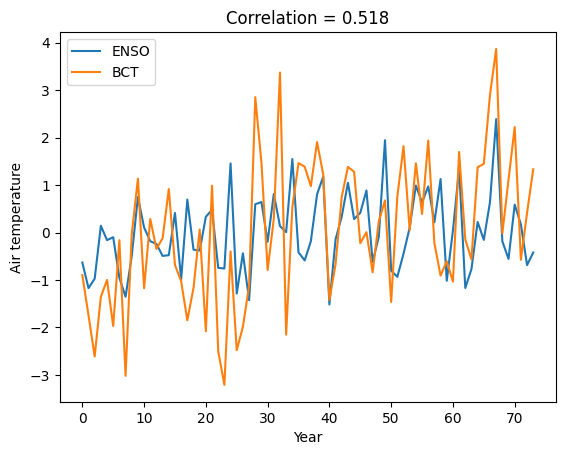

In [39]:
plt.plot(shifted_Xregion, label='ENSO')
plt.plot(shifted_Yregion, label='BCT')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Air temperature')
plt.title(f'Correlation = {np.corrcoef(shifted_Xregion, shifted_Yregion)[0, 1].round(3)}')

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
shifted_Xregion.shape, shifted_Yregion.shape

((74,), (74,))

In [22]:
np.save('datauniv.npy', np.hstack([shifted_Xregion.reshape(-1, 1), shifted_Yregion.reshape(-1, 1)]))

In [41]:
np.save('datauniv_unshifted.npy', np.hstack([reshaped_Xregion.reshape(-1, 1), reshaped_Yregion[:-1].reshape(-1, 1)]))

In [23]:
model = LinearRegression()
model.fit(shifted_Xregion.reshape(-1, 1), shifted_Yregion.reshape(-1, 1))
res = model.predict(shifted_Xregion.reshape(-1, 1))